   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 19.1 MB/s eta 0:00:00
Processing fragment: 124_001


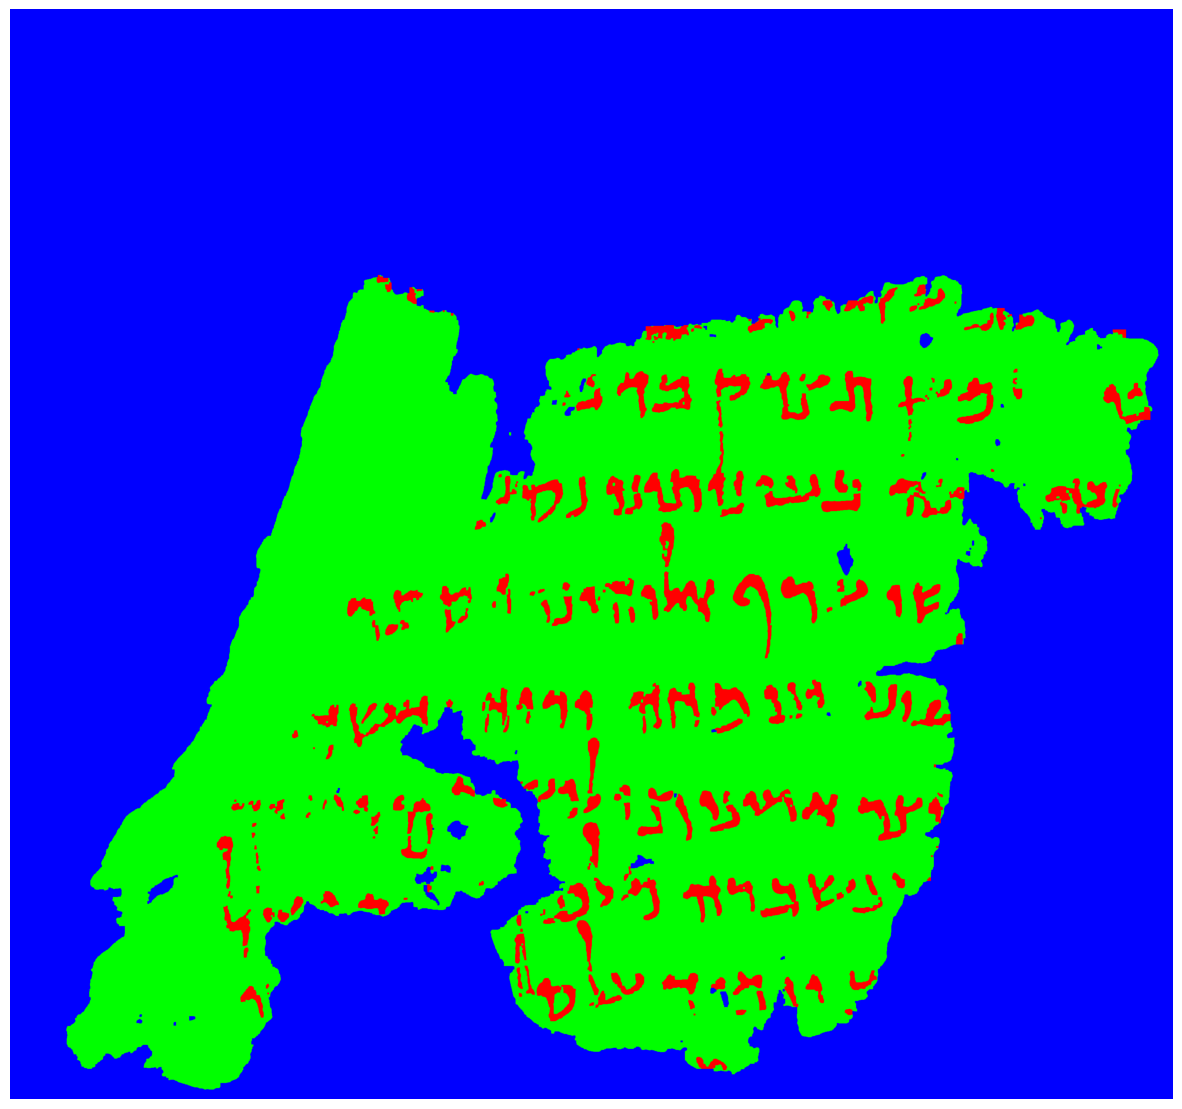

Processing fragment: 124_002


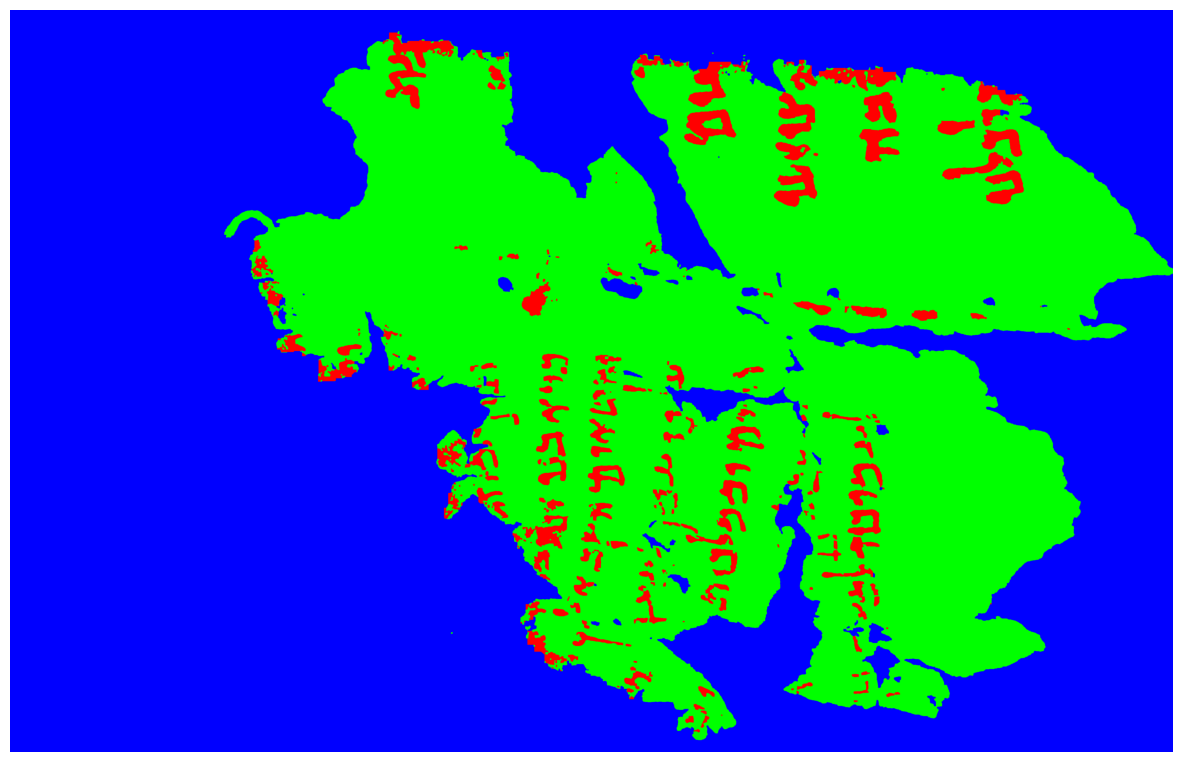

Processing fragment: 124_004


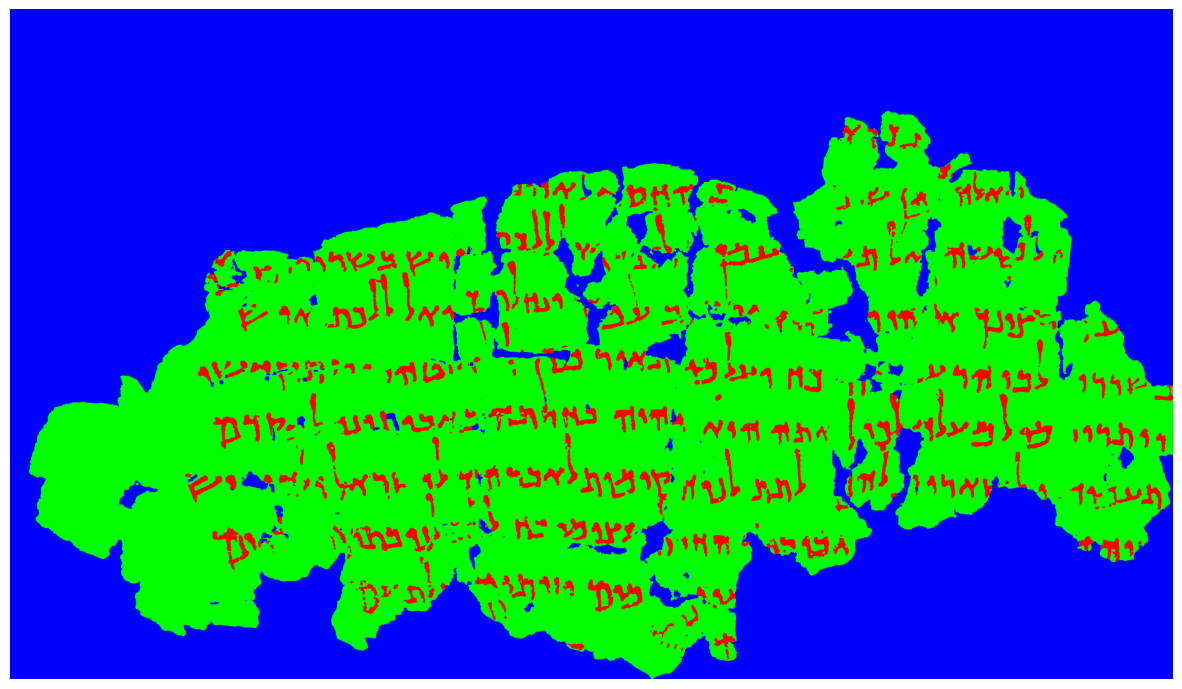

Processing fragment: 124_005


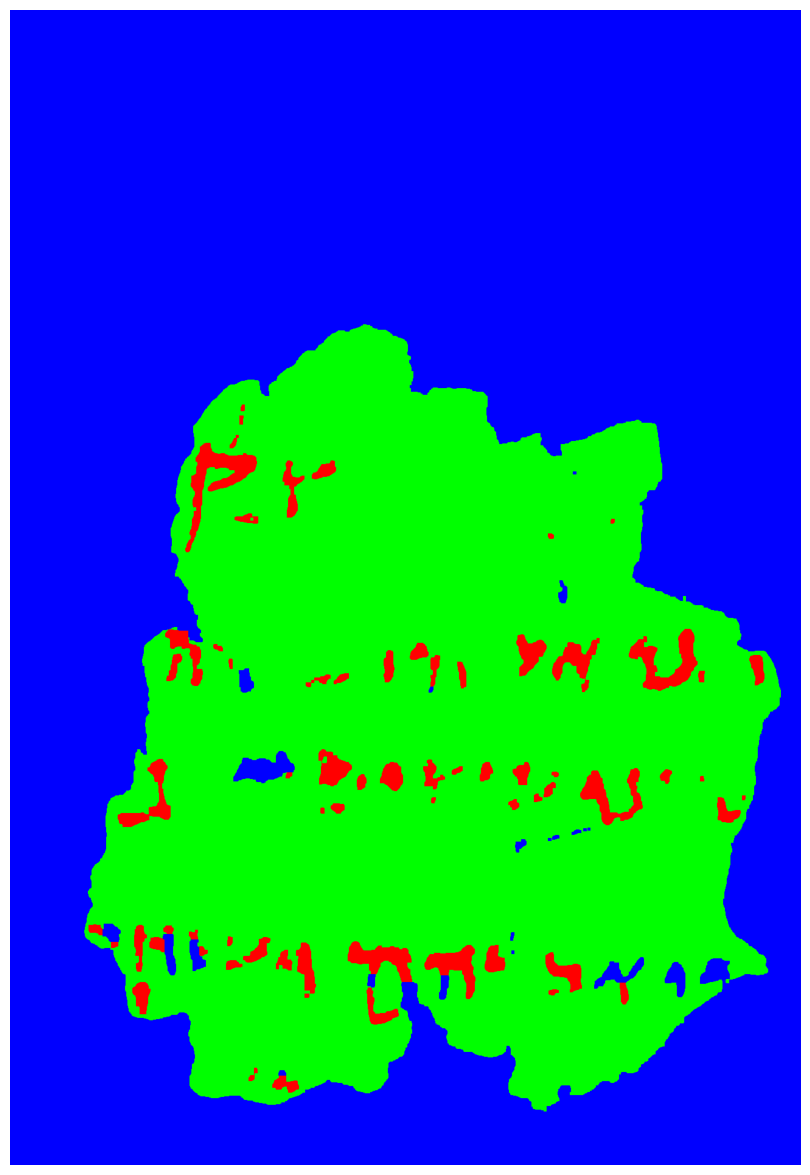

Processing fragment: 124_006


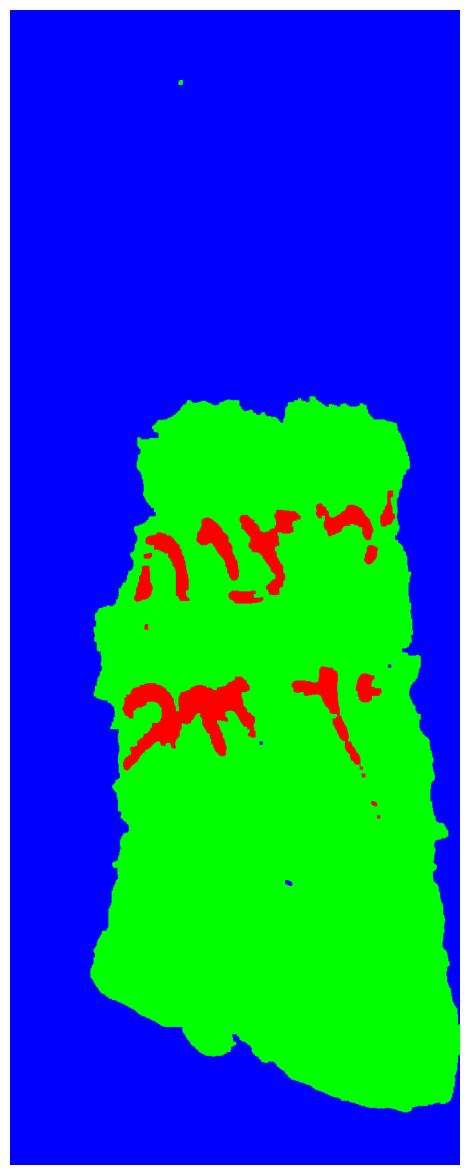

Processing fragment: 124_007


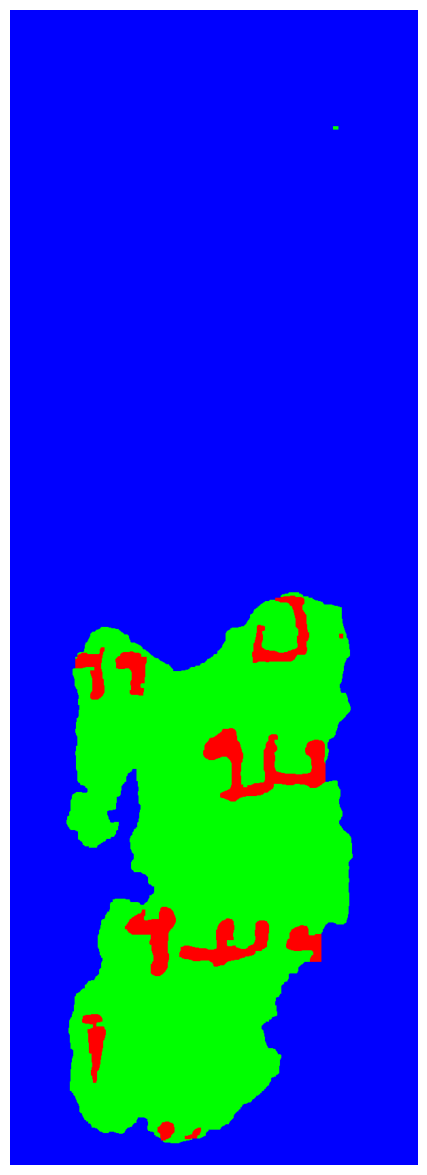

Processing fragment: 124_008


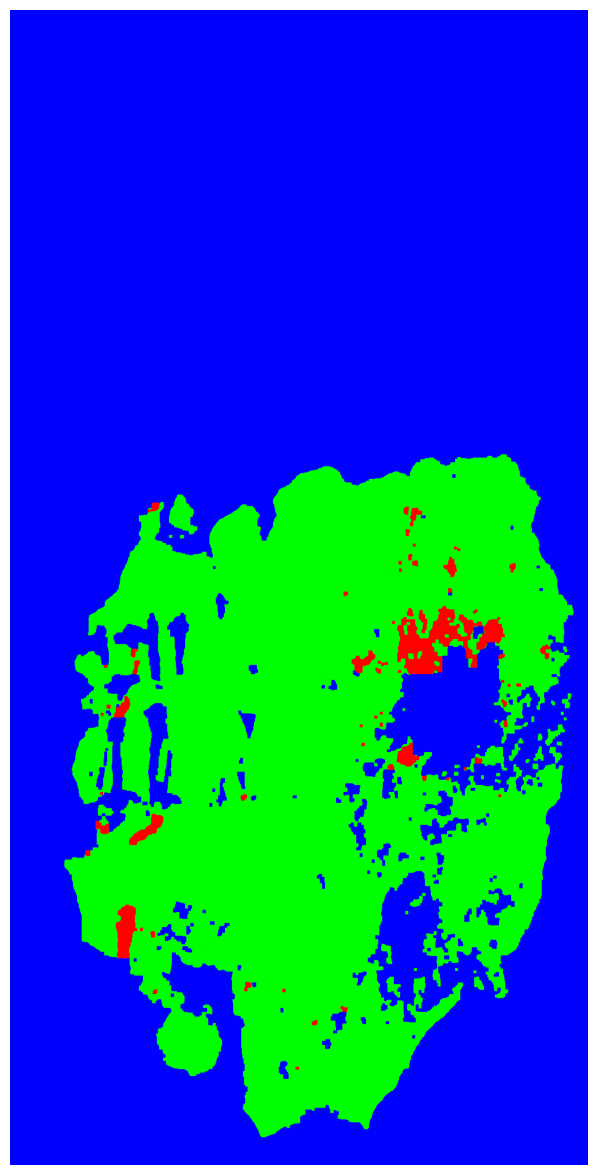

Processing fragment: 124_009


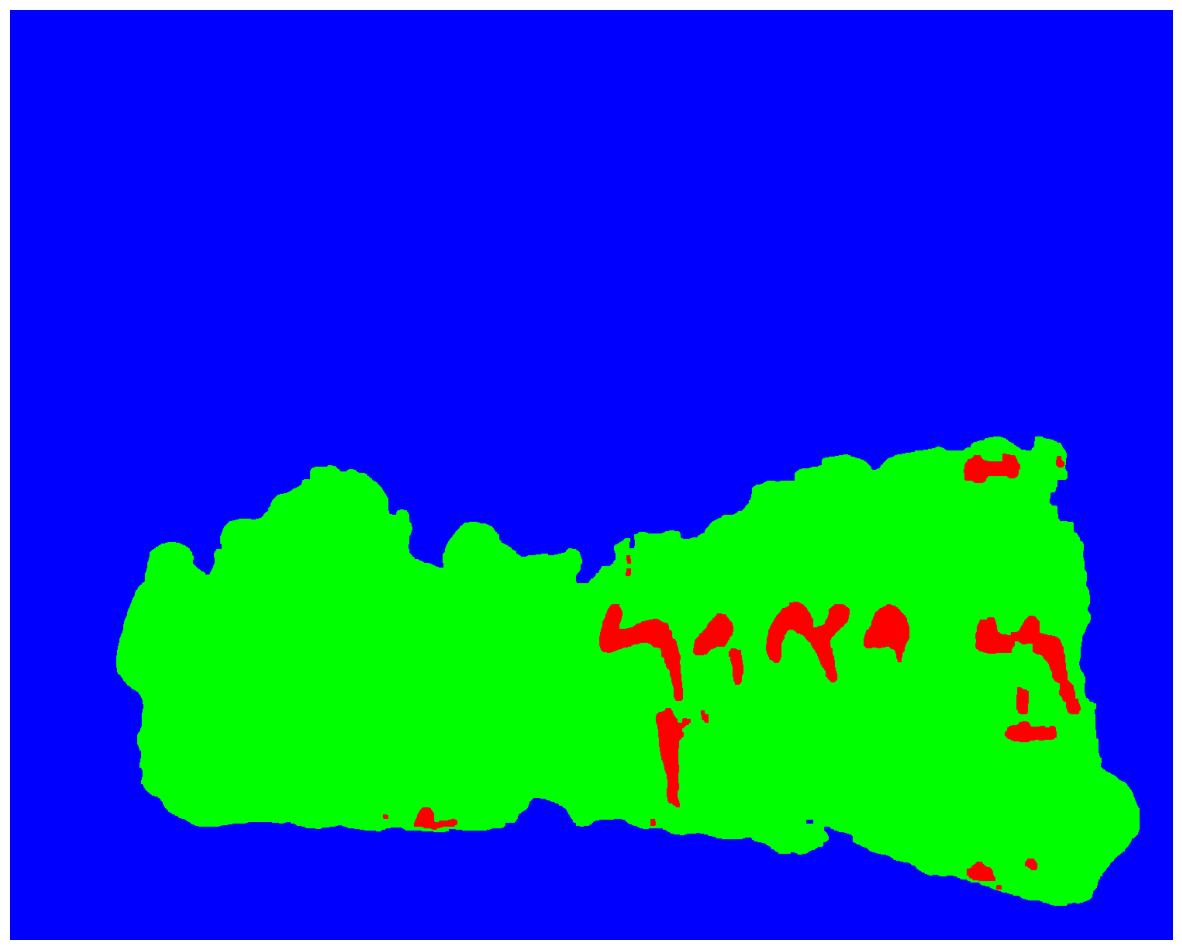

Processing fragment: 198_006


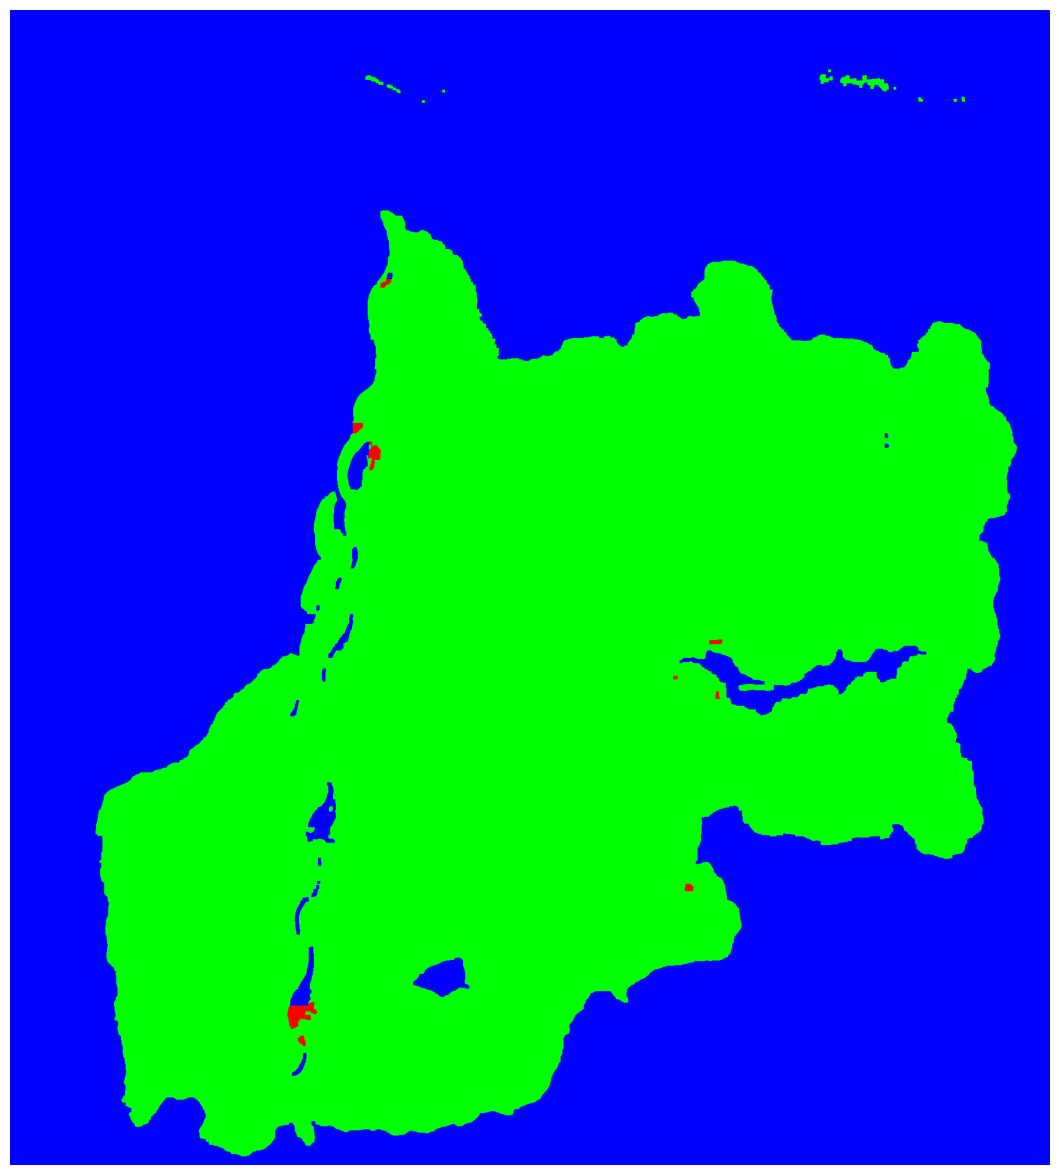

Processing fragment: 198_007


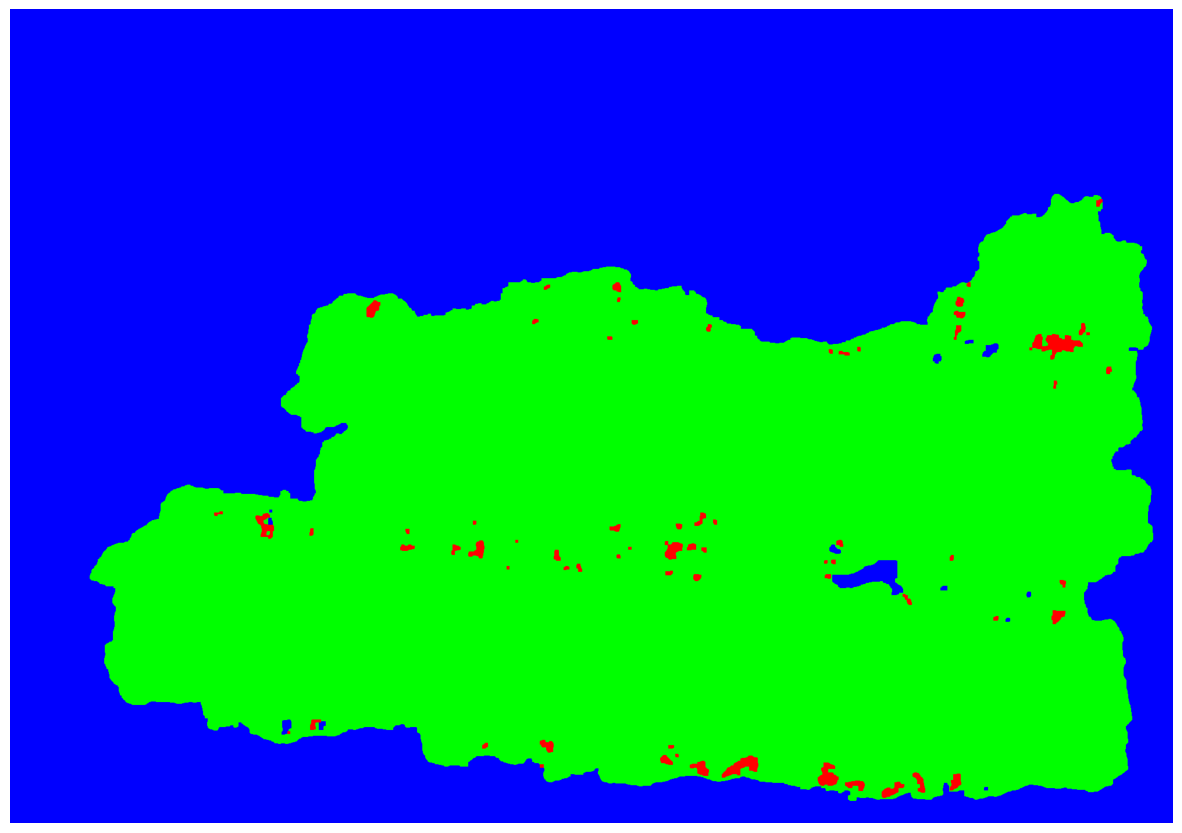

Processing fragment: 690_003


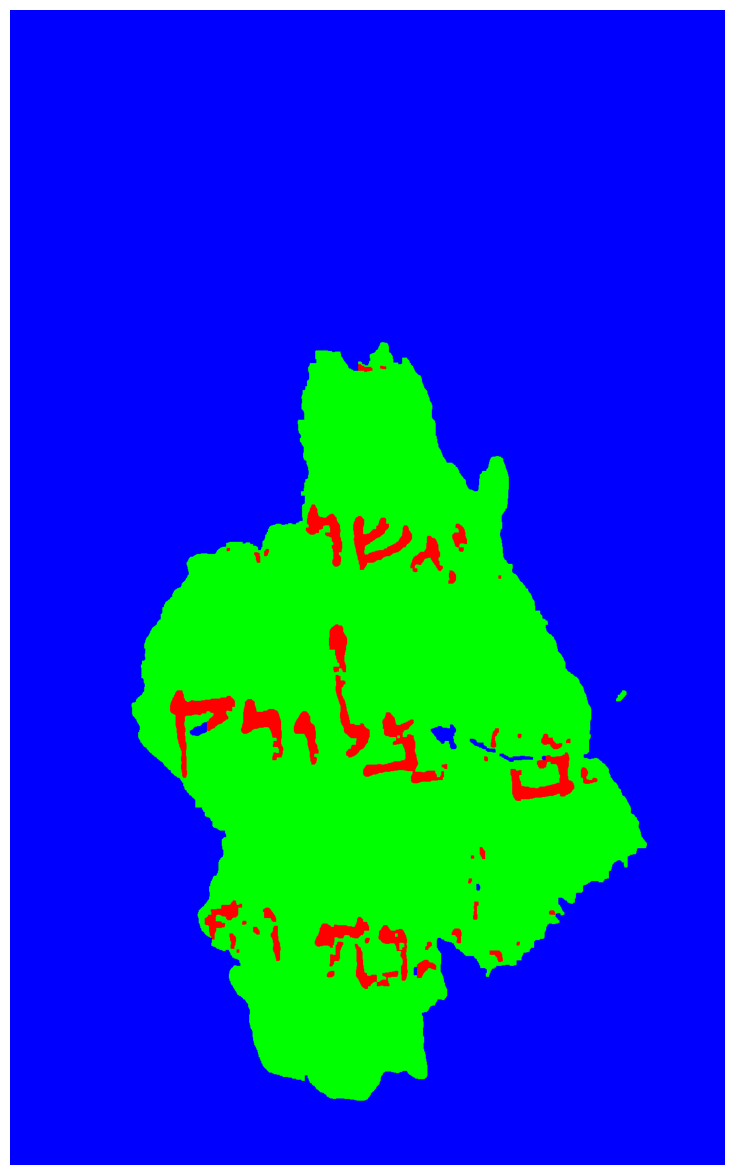

Processing fragment: 690_004


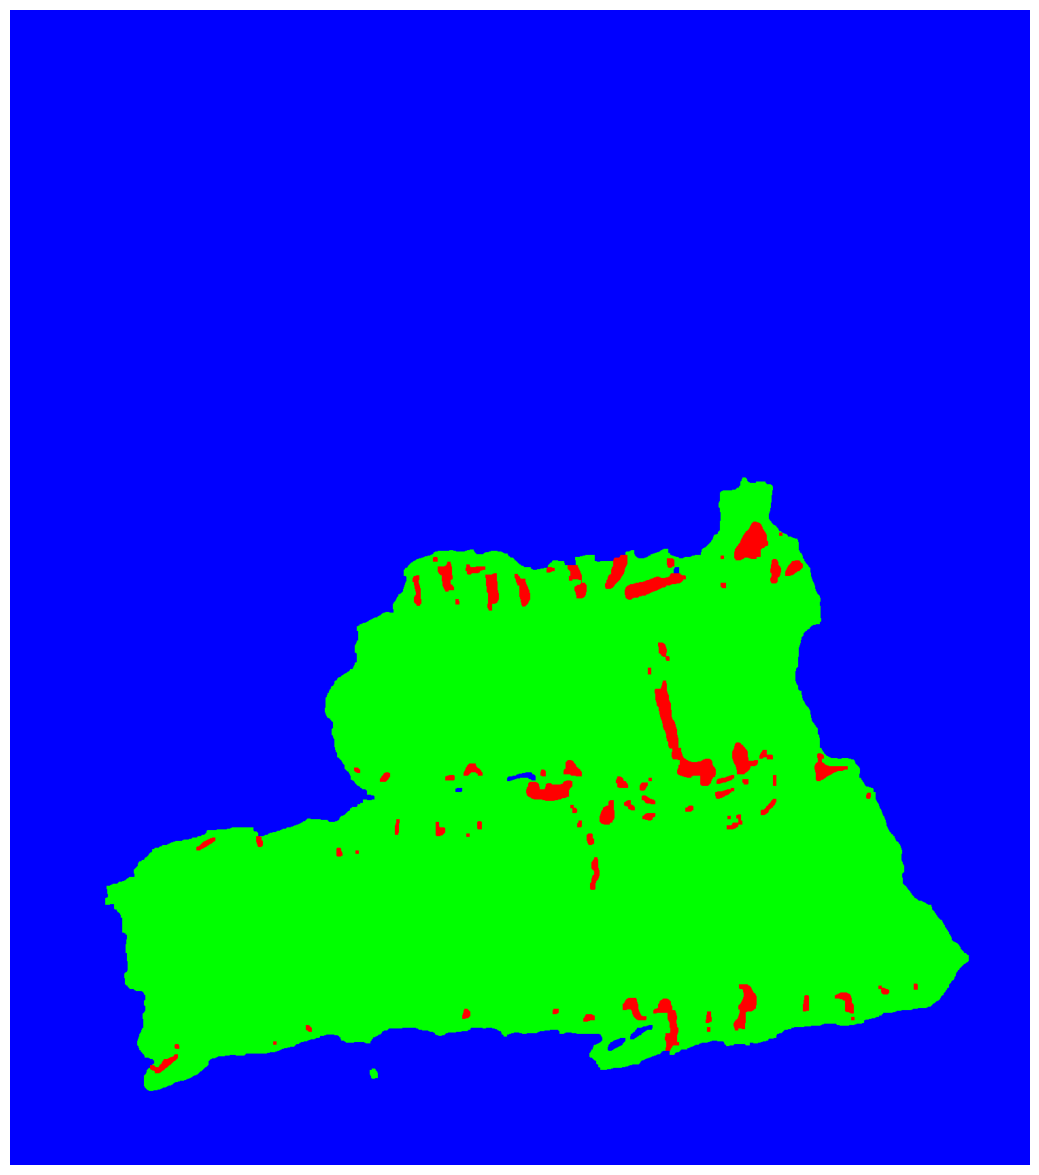

Processing fragment: 690_007


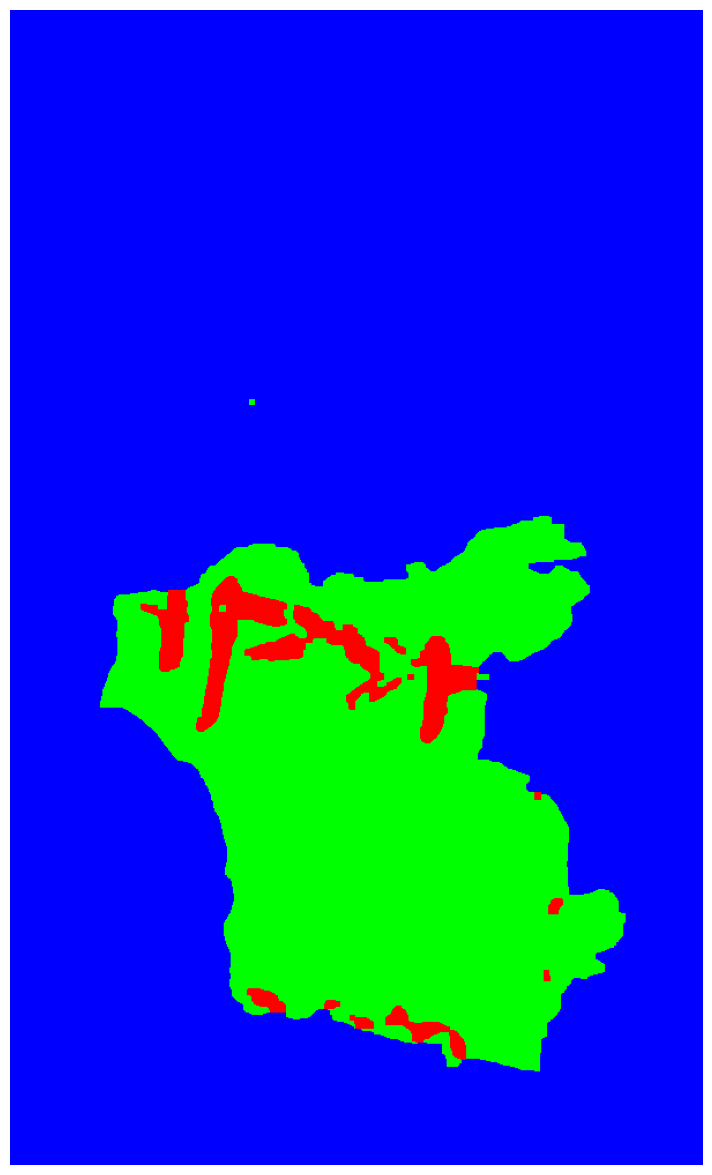

Processing fragment: 690_008


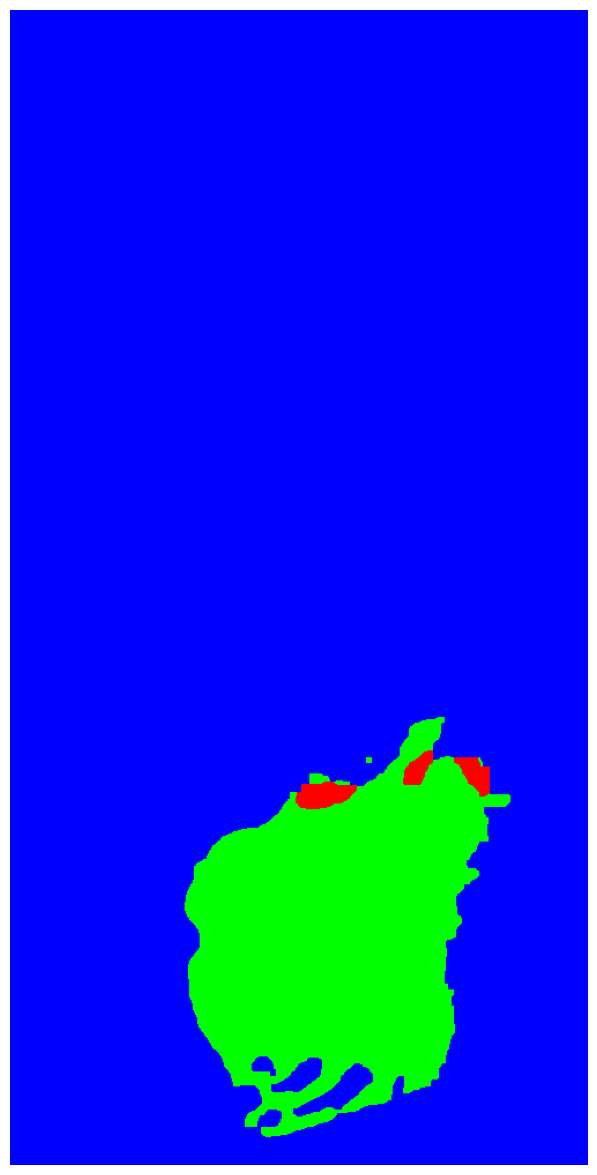

Processing fragment: 690_011


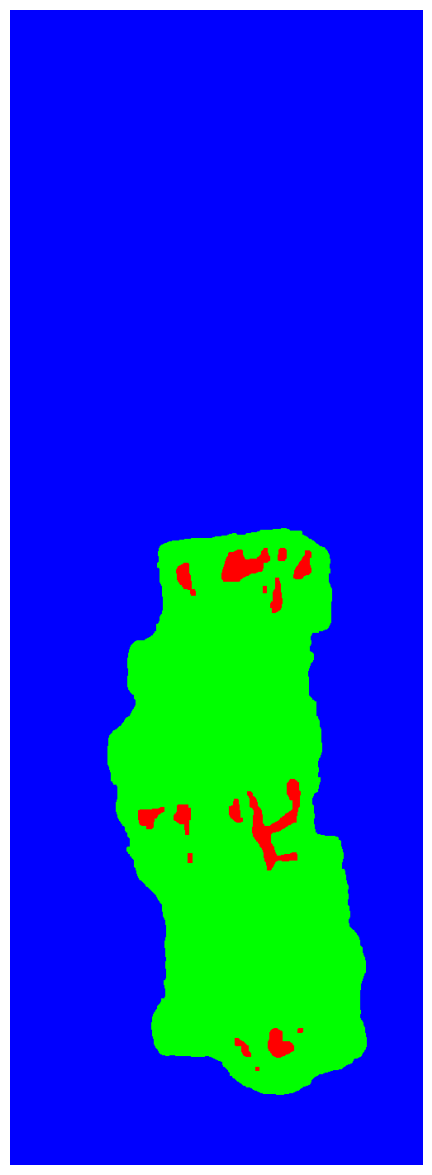

Processing fragment: 690_014


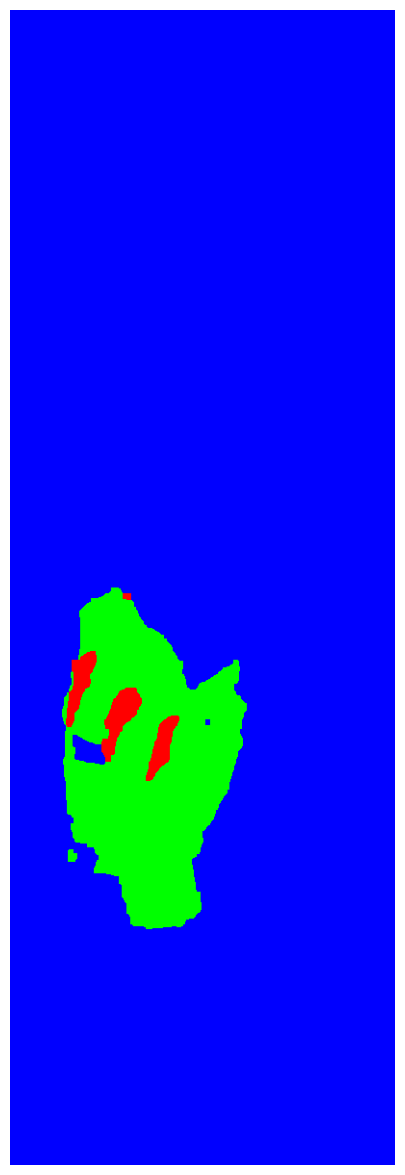

Processing fragment: 690_015


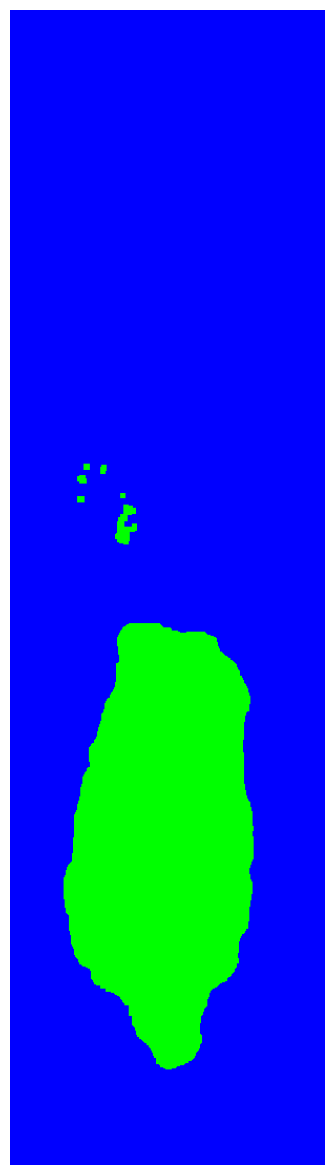

Processing fragment: 690_016


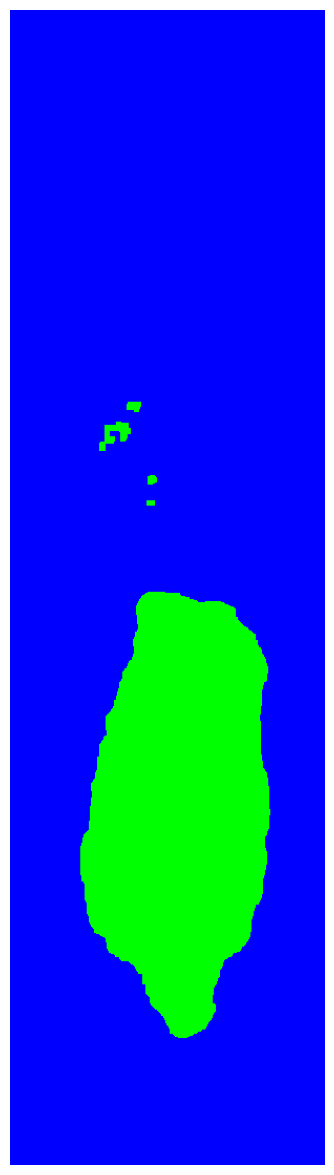

Processing fragment: 690_018


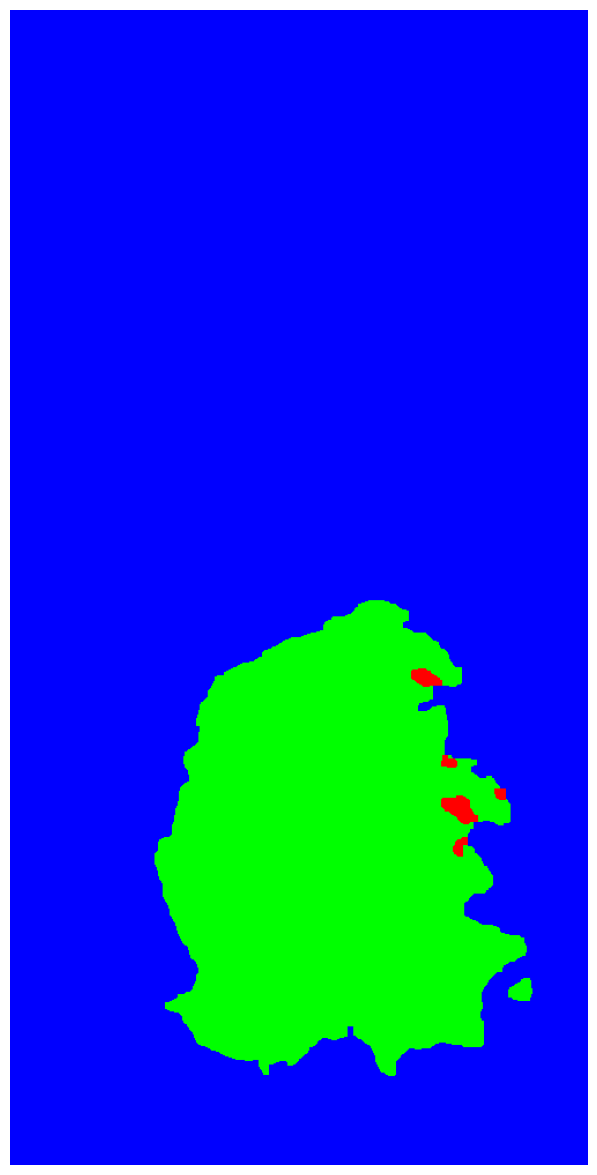

Processing fragment: 690_019


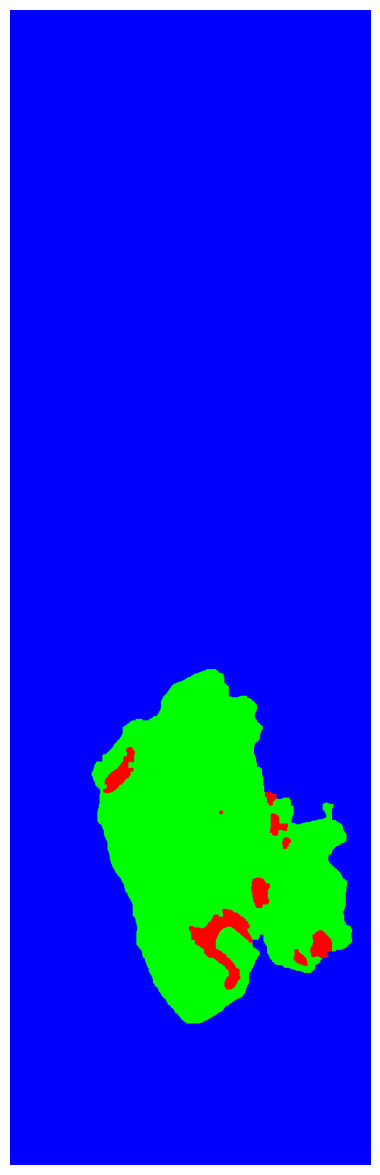

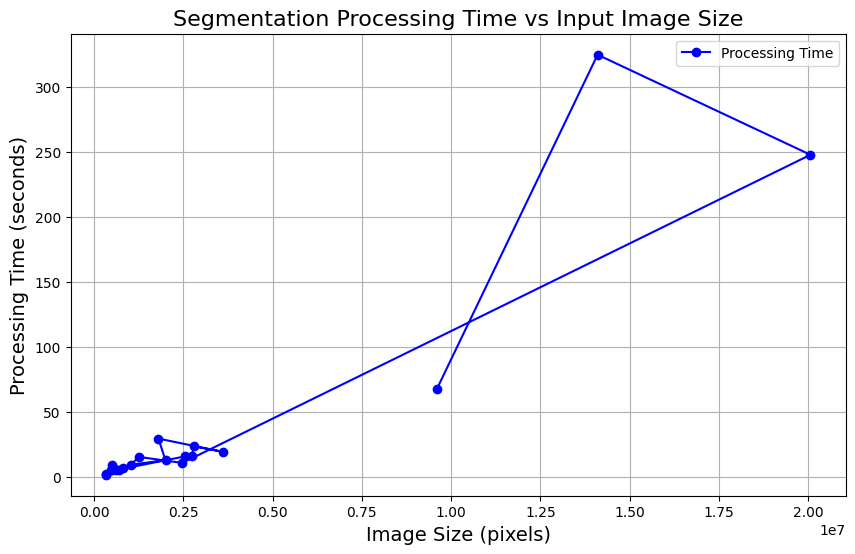

In [1]:
!pip install pymaxflow
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow
import time

# List of fragments to process
fragments = [
    '124_001', '124_002', '124_004', '124_005', '124_006', '124_007', '124_008', '124_009',
    '198_006', '198_007', '690_003', '690_004', '690_007', '690_008', '690_011', '690_014',
    '690_015', '690_016', '690_018', '690_019'
]

# Base paths
input_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/multispectral_images/"
#output_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/MSEM_results/ablation"
#ink_output_dir = os.path.join(output_base, "ink_masks/")
#parchment_output_dir = os.path.join(output_base, "parchment_masks/")

# Ensure output directories exist
#os.makedirs(ink_output_dir, exist_ok=True)
#os.makedirs(parchment_output_dir, exist_ok=True)

# Initialize lists to store image size and corresponding processing time
image_sizes = []
processing_times = []

def create_mask(i1, i12, conditions):
    mask = np.ones_like(i1, dtype=bool)
    for cond in conditions:
        mask &= cond
    result = np.zeros_like(i1)
    result[mask] = 255
    return np.uint8(result)

for fragment in fragments:
    print(f"Processing fragment: {fragment}")
    # Load images
    i1_path = os.path.join(input_base, fragment + "_001.tif")
    i12_path = os.path.join(input_base, fragment + "_012.tif")
    i1 = cv2.imread(i1_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
    i12 = cv2.imread(i12_path, cv2.IMREAD_UNCHANGED).astype(np.float64)

    # Record the start time
    start_time = time.time()

    # Perform segmentation operations
    parchment_mask = create_mask(i1, i12, [
        i12 - i1 > 313
    ])
    ink_mask = create_mask(i1, i12, [
        i12 - i1 > 78, i12 - i1 <= 280, i1 > 92, i1 <= 150
    ])
    ink_contour_mask = create_mask(i1, i12, [
        i12 - i1 > 225, i12 - i1 <= 346, i1 > 92, i1 <= 155
    ])

    inverse_parchment_mask = cv2.bitwise_not(parchment_mask)
    parchment_and_ink_contour_mask = cv2.bitwise_or(parchment_mask, ink_contour_mask)
    parchment_and_ink_contour_and_ink_mask = cv2.bitwise_or(parchment_and_ink_contour_mask, ink_mask)
    inverse_parchment_and_ink_contour_and_ink_mask = cv2.bitwise_not(parchment_and_ink_contour_and_ink_mask)

    # Graph-cut segmentation function
    def graph_cut_segmentation(imagetoseg, h, i):
        white_pixels_mask = imagetoseg > 0
        dist_transform_h = cv2.distanceTransform(255 - h, cv2.DIST_L2, 5)
        dist_transform_i = cv2.distanceTransform(255 - i, cv2.DIST_L2, 5)
        data_cost_h = np.where(white_pixels_mask, 1 / (1 + dist_transform_h), np.inf)
        data_cost_i = np.where(white_pixels_mask, 1 / (1 + dist_transform_i), np.inf)

        num_white_pixels = np.sum(white_pixels_mask)
        g = maxflow.Graph[float](num_white_pixels, num_white_pixels * 4)
        node_ids = g.add_nodes(num_white_pixels)

        white_pixel_indices = np.argwhere(white_pixels_mask)
        node_id_map = np.full(white_pixels_mask.shape, -1, dtype=int)
        node_id_map[white_pixels_mask] = node_ids

        for node_id, (y, x) in enumerate(white_pixel_indices):
            g.add_tedge(node_id, data_cost_h[y, x], data_cost_i[y, x])

        for y, x in white_pixel_indices:
            if y + 1 < white_pixels_mask.shape[0] and white_pixels_mask[y + 1, x]:
                g.add_edge(node_id_map[y, x], node_id_map[y + 1, x], 1, 1)
            if x + 1 < white_pixels_mask.shape[1] and white_pixels_mask[y, x + 1]:
                g.add_edge(node_id_map[y, x], node_id_map[y, x + 1], 1, 1)

        g.maxflow()
        result = np.zeros_like(white_pixels_mask, dtype=bool)
        for node_id, (y, x) in enumerate(white_pixel_indices):
            result[y, x] = g.get_segment(node_id)

        return result.astype(np.uint8) * 255

    # Apply graph-cut segmentation
    riceholeback = inverse_parchment_and_ink_contour_and_ink_mask
    clean_ink_contour = graph_cut_segmentation(ink_contour_mask, riceholeback, parchment_mask)
    ink = graph_cut_segmentation(inverse_parchment_mask, parchment_mask, clean_ink_contour)

    # Clean the masks with morphological operations
    def clean_mask(mask):
        kernel = np.ones((5, 5), np.uint8)
        clean_white = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        inverted_image = cv2.bitwise_not(clean_white)
        clean_black = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
        return cv2.bitwise_not(clean_black)

    clean_ink = clean_mask(ink)
    inkpar = cv2.bitwise_or(parchment_mask, ink)
    inkpar = cv2.bitwise_or(inkpar, clean_ink)
    clean_inkpar = clean_mask(inkpar)
    background = cv2.bitwise_not(clean_inkpar)

    # Save the masks
    #ink_output_path = os.path.join(ink_output_dir, f"{fragment}.png")
    #parchment_output_path = os.path.join(parchment_output_dir, f"{fragment}.png")
    #cv2.imwrite(ink_output_path, clean_ink)
    #cv2.imwrite(parchment_output_path, clean_inkpar)

    # Record the end time and calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time

    # Store image size and processing time
    image_size = i1.shape[0] * i1.shape[1]
    image_sizes.append(image_size)
    processing_times.append(processing_time)

    # Create a color visualization
    redink_blueback_greenparchment = np.zeros((i1.shape[0], i1.shape[1], 3), dtype=np.uint8)
    redink_blueback_greenparchment[clean_inkpar == 255] = [0, 255, 0]
    redink_blueback_greenparchment[background == 255] = [255, 0, 0]
    redink_blueback_greenparchment[clean_ink == 255] = [0, 0, 255]

    # Display the visualization
    plt.figure(figsize=(15, 15))
    plt.imshow(redink_blueback_greenparchment[:, :, ::-1])
    plt.axis('off')
    plt.show()

# Plotting the processing time vs image size
plt.figure(figsize=(10, 6))
plt.plot(image_sizes, processing_times, 'o-', color='b', label='Processing Time')
plt.xlabel('Image Size (pixels)', fontsize=14)
plt.ylabel('Processing Time (seconds)', fontsize=14)
plt.title('Segmentation Processing Time vs Input Image Size', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()


In [2]:
image_sizes

[9600000,
 14100000,
 20060000,
 2470000,
 1260000,
 1020000,
 2000000,
 1800000,
 3600000,
 2800000,
 2730000,
 2550000,
 600000,
 500000,
 700000,
 480000,
 330000,
 330000,
 500000,
 800000]

In [3]:
processing_times

[67.75817656517029,
 324.76435589790344,
 247.81404566764832,
 10.84516453742981,
 15.445241212844849,
 9.463119268417358,
 12.918235301971436,
 29.568408012390137,
 19.43785834312439,
 23.510092735290527,
 16.383894681930542,
 15.898508787155151,
 5.278065919876099,
 5.055265188217163,
 5.595272779464722,
 5.3328697681427,
 1.7819850444793701,
 1.974609136581421,
 9.363974332809448,
 6.765048503875732]

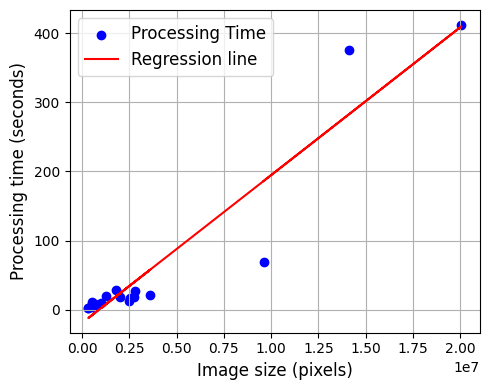

In [ ]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow
import time
#!pip install pymaxflow

# ... (rest of your code remains the same) ...

# ... (your existing code for processing fragments) ...

# Plotting the processing time vs image size with a scatter plot and regression line
plt.figure(figsize=(5, 4))
plt.scatter(image_sizes, processing_times, color='b', label='Processing Time')

# Add a regression line to visualize the relationship
z = np.polyfit(image_sizes, processing_times, 1)
p = np.poly1d(z)
plt.plot(image_sizes, p(image_sizes), "r-", label="Regression line")
plt.xlabel('Image size (pixels)', fontsize='larger')
plt.ylabel('Processing time (seconds)', fontsize='larger')
plt.grid(True)
plt.legend(fontsize='larger')
plt.tight_layout()
plt.savefig('time_versus_image_size.png', dpi=300, format='png')
plt.show()


# # Plotting the processing time for each fragment individually as a bar chart
# plt.figure(figsize=(12, 6))
# plt.bar(fragments, processing_times, color='skyblue')
# plt.xlabel('Fragments', fontsize=14)
# plt.ylabel('Processing Time (seconds)', fontsize=14)
# plt.title('Processing Time for Each Fragment', fontsize=16)
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

# # Create a histogram of processing times to understand the distribution
# plt.figure(figsize=(8, 6))
# plt.hist(processing_times, bins=10, color='lightgreen', edgecolor='black')
# plt.xlabel('Processing Time (seconds)', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Distribution of Processing Times', fontsize=16)
# plt.show()

In [ ]:

average_processing_time = sum(processing_times) / len(processing_times) if processing_times else 0
print(f"Average processing time per image: {average_processing_time:.4f} seconds")

Average processing time per image: 53.7166 seconds


In [ ]:


# Calculate the average processing time per patch of 1000x1000 pixels
patch_size = 1000 * 1000
average_processing_time_per_patch = [
    processing_time / (image_size / patch_size)
    for processing_time, image_size in zip(processing_times, image_sizes)
]

average_processing_time_per_patch = (
    sum(average_processing_time_per_patch) / len(average_processing_time_per_patch)
    if average_processing_time_per_patch
    else 0
)

print(
    f"Average processing time per patch of 1000x1000 pixels: {average_processing_time_per_patch:.4f} seconds"
)

Average processing time per patch of 1000x1000 pixels: 11.0665 seconds
